In [2]:
%matplotlib inline
import os
import pandas as pd
from glob import glob
import numpy as np

In [3]:

!wget https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0

--2023-05-06 07:54:48--  https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/4jw31k5mlzcmgis/genres.tar.gz [following]
--2023-05-06 07:54:48--  https://www.dropbox.com/s/raw/4jw31k5mlzcmgis/genres.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucad7c04693c69644ea19a571aab.dl.dropboxusercontent.com/cd/0/inline/B7jDFcIQRsLFha68FQAwGKuWDbQ_52hfmGqykZcrG_ao0Xsb9EwyQAGrIFOIZg__j7HLLlUhUiS1IEgIK3ZgjePR8SSYEU7eDOFVaVIFaSVfIfJ0_qu3nvvYRZFnAtTRZdypcd45CfimBHTX_e7Cz2nMSolGoSrF4-j6Q07V34YmpA/file# [following]
--2023-05-06 07:54:49--  https://ucad7c04693c69644ea19a571aab.dl.dropboxusercontent.com/cd/0/inline/B7jDFcIQRsLFha68FQAwGKuWDbQ_52hfmGqykZcrG_ao0Xsb9EwyQAGrIFOIZg__j7HLLlUh

In [4]:

import tarfile

In [5]:

data = tarfile.open("genres.tar.gz?dl=0")

In [6]:

data.extractall('./Audiodata')

In [7]:

data.close()

In [8]:
!pip install path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc
from path import Path
import IPython.display as ipd
     

In [10]:
import os
os.mkdir('train')
os.mkdir('test')

In [11]:

glob('./train/*')

[]

In [12]:

file_list=list(glob("./Audiodata/genres/blues/*"))

In [13]:
genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
     

In [14]:

audio_fpath = "/content/Audiodata/genres/blues/"
audio_clips = os.listdir(audio_fpath)


print("Number of .wav files in audio folder = ",len(audio_clips))

Number of .wav files in audio folder =  100


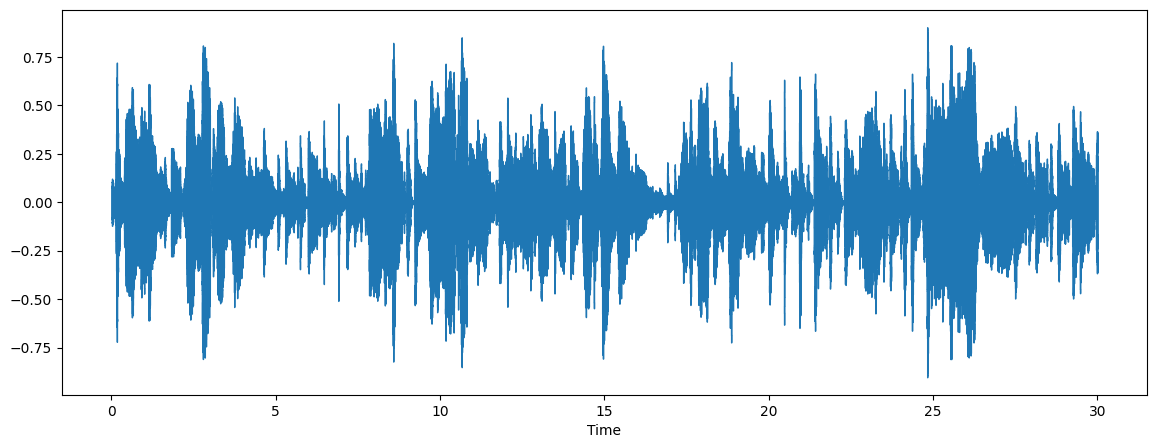

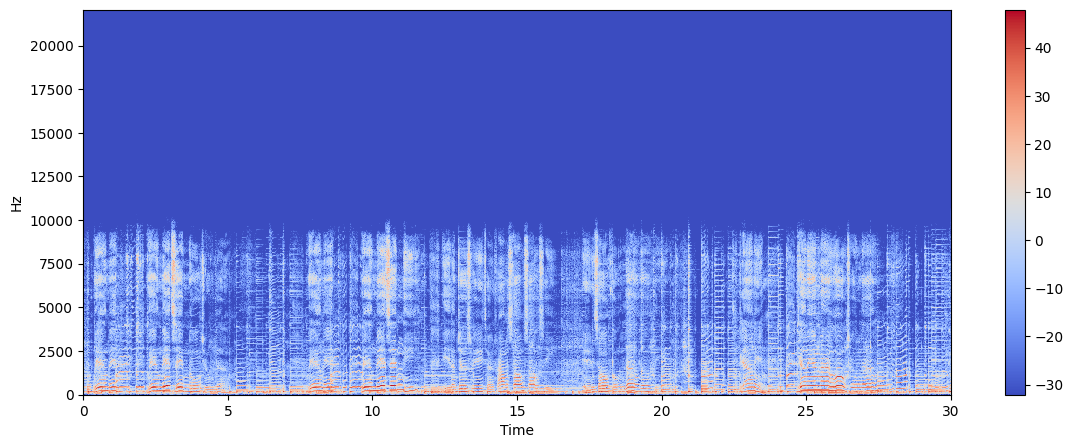

In [16]:
x, sr = librosa.load(audio_fpath+audio_clips[2], sr=44100)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [17]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()
     

In [18]:
import csv
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./Audiodata/genres/{g}'):
        songname = f'./Audiodata/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
data = pd.read_csv('data.csv')
data = data.drop(['filename'],axis=1)
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.306442,0.113431,1156.202363,1497.758884,2170.511875,0.058613,-233.857513,136.172089,3.271318,48.931213,...,-2.231880,3.964033,5.318362,0.812266,-1.097914,-4.539752,-2.434786,3.313449,-0.614279,blues
1,0.280721,0.101915,1210.457126,1498.054609,2522.543080,0.052483,-227.268860,137.730698,-14.493466,63.555702,...,-9.429529,-10.923911,3.562557,4.137706,0.095544,-2.972545,-1.378875,7.541176,-3.037463,blues
2,0.280554,0.124669,1649.287754,2190.221833,3761.610587,0.052926,-233.750824,101.178276,17.649765,23.733782,...,-6.057174,-5.068858,1.067393,-5.785368,-8.311131,-11.389136,-6.727949,-10.025587,-14.032895,blues
3,0.365807,0.065685,1353.329119,1757.331005,2882.315904,0.043959,-287.923553,123.971024,5.456123,33.684544,...,-3.180659,-5.557003,-6.786621,-2.644233,-2.982432,-3.381138,-1.861497,1.835920,-4.896512,blues
4,0.376715,0.140921,1239.687999,1659.985629,2519.043101,0.050908,-206.281158,126.620331,10.590663,43.215721,...,3.663423,-1.456047,-1.701555,-7.154654,1.186417,-6.225801,0.601273,-1.604264,-0.539220,blues


In [20]:

genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
print(y)
     

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [21]:

scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train


array([0, 4, 7, 3, 5, 9, 9, 1, 8, 1, 0, 6, 7, 3, 2, 1, 8, 2, 9, 3, 6, 0,
       6, 2, 8, 6, 5, 1, 4, 3, 5, 9, 9, 1, 1, 6, 4, 8, 2, 5, 2, 4, 7, 1,
       1, 2, 7, 1, 1, 2, 1, 8, 1, 2, 8, 1, 4, 5, 2, 6, 5, 8, 8, 6, 4, 5,
       9, 7, 3, 1, 2, 8, 7, 2, 7, 6, 9, 7, 1, 0, 1, 2, 1, 3, 3, 2, 9, 8,
       7, 7, 3, 3, 5, 4, 5, 8, 9, 4, 6, 5, 8, 8, 1, 2, 5, 8, 3, 2, 9, 2,
       4, 4, 0, 7, 3, 0, 1, 2, 7, 9, 8, 9, 7, 7, 1, 5, 4, 6, 9, 6, 7, 1,
       5, 2, 3, 6, 7, 6, 3, 2, 8, 7, 0, 4, 7, 7, 2, 7, 2, 4, 0, 2, 6, 1,
       9, 6, 9, 8, 4, 3, 7, 0, 1, 8, 7, 8, 9, 5, 8, 7, 6, 9, 1, 4, 1, 0,
       0, 0, 5, 5, 2, 5, 7, 1, 9, 3, 3, 6, 2, 4, 9, 0, 8, 2, 6, 2, 5, 1,
       9, 5, 3, 5, 6, 9, 9, 6, 4, 8, 5, 3, 2, 1, 4, 4, 8, 7, 9, 0, 3, 4,
       4, 0, 4, 4, 6, 0, 8, 0, 0, 1, 0, 8, 8, 6, 6, 4, 2, 9, 8, 2, 6, 8,
       9, 0, 5, 3, 0, 2, 2, 8, 9, 2, 0, 8, 8, 7, 3, 1, 1, 7, 9, 2, 3, 1,
       8, 2, 5, 7, 3, 8, 2, 0, 8, 6, 0, 2, 5, 1, 1, 5, 2, 4, 8, 8, 8, 7,
       5, 2, 8, 9, 1, 2, 5, 2, 7, 0, 9, 6, 4, 4, 0,

In [23]:
from tensorflow.keras.layers import Dense, Activation
model_ann = models.Sequential()
model_ann.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(layers.Dense(128, activation='relu'))
model_ann.add(layers.Dense(64, activation='relu'))
model_ann.add(layers.Dense(10, activation='softmax'))
X_train.shape[1]
     

26

In [24]:

model_ann.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [32]:

print("Fit model on training data")
history = model_ann.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=20
)

Fit model on training data
Epoch 1/20
7/7 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 0.9987
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0019 - accuracy: 0.9987
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 0.9987
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 0.9987
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 0.9987
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 0.9987
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 0.9987
Epoch 8/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 0.9987
Epoch 9/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 0.9987
Epoch 10/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 0.9987
Epoch 11/20


In [33]:
test_loss, test_acc = model_ann.evaluate(X_test,y_test)
print('test_acc: ',test_acc)
print('test_loss: ',test_loss)

7/7 [==============================] - 0s 2ms/step - loss: 3.7039 - accuracy: 0.6950
test_acc:  0.6949999928474426
test_loss:  3.703859567642212


In [34]:
predictions = model_ann.predict(X_test)
print("Predicted : " ,predictions[0])
print("Actual : ",y_test[0])

7/7 [==============================] - 0s 2ms/step
Predicted :  [9.9999994e-01 5.6655339e-31 4.6446555e-22 4.1350709e-18 0.0000000e+00
 4.8601847e-17 0.0000000e+00 1.5851932e-27 1.4464241e-12 8.1579188e-27]
Actual :  0
